In [3]:
# Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

In [4]:
# Load the file
movie=pd.read_csv("C:/Users/kfeng3/Desktop/cleaneddatafinal2.csv")
movie.head()

,release_date,title,original_language,popularity,production_companies,production_countries,adjbudget,adjrevenue,runtime,spoken_languages,vote_average,vote_count,genres
0,9/4/1916,Intolerance,1,0,0,1,4.163937e+05,9.057936e+06,197,1,7.4,60,8
1,1/10/1927,Metropolis,0,1,1,0,9.104546e+07,6.393648e+05,153,0,8.0,657,8
2,1/30/1929,Pandora's Box,0,0,0,0,1.500000e+07,2.036248e+07,109,0,7.6,45,8
3,2/8/1929,The Broadway Melody,1,0,0,1,3.790000e+05,4.358000e+06,100,1,5.0,19,8
4,11/15/1930,Hell's Angels,1,0,0,1,3.859150e+06,7.816000e+06,127,0,6.1,19,10


In [84]:
#Rescaling the Data
movie["genres"]=((movie["genres"]-movie["genres"].min())/(movie["genres"].max()-movie["genres"].min()))*1
movie["adjbudget"]=((movie["adjbudget"]-movie["adjbudget"].min())/(movie["adjbudget"].max()-movie["adjbudget"].min()))*1
movie["adjrevenue"]=((movie["adjrevenue"]-movie["adjrevenue"].min())/(movie["adjrevenue"].max()-movie["adjrevenue"].min()))*1
movie["runtime"]=((movie["runtime"]-movie["runtime"].min())/(movie["runtime"].max()-movie["runtime"].min()))*1
movie["vote_average"]=((movie["vote_average"]-movie["vote_average"].min())/(movie["vote_average"].max()-movie["vote_average"].min()))*1
movie["vote_count"]=((movie["vote_count"]-movie["vote_count"].min())/(movie["vote_count"].max()-movie["vote_count"].min()))*1

In [5]:
#Print standardized data
movie.head()

,release_date,title,original_language,popularity,production_companies,production_countries,adjbudget,adjrevenue,runtime,spoken_languages,vote_average,vote_count,genres
0,9/4/1916,Intolerance,1,0,0,1,4.163937e+05,9.057936e+06,197,1,7.4,60,8
1,1/10/1927,Metropolis,0,1,1,0,9.104546e+07,6.393648e+05,153,0,8.0,657,8
2,1/30/1929,Pandora's Box,0,0,0,0,1.500000e+07,2.036248e+07,109,0,7.6,45,8
3,2/8/1929,The Broadway Melody,1,0,0,1,3.790000e+05,4.358000e+06,100,1,5.0,19,8
4,11/15/1930,Hell's Angels,1,0,0,1,3.859150e+06,7.816000e+06,127,0,6.1,19,10


In [9]:
#Data Exploration: K-Means Clustering 

#Before kmeans, dropping the non-relevant strings 
movie1=movie.drop(columns=["release_date", "title"])
movie1.head()

,original_language,popularity,production_companies,production_countries,adjbudget,adjrevenue,runtime,spoken_languages,vote_average,vote_count,genres
0,1,0,0,1,4.163937e+05,9.057936e+06,197,1,7.4,60,8
1,0,1,1,0,9.104546e+07,6.393648e+05,153,0,8.0,657,8
2,0,0,0,0,1.500000e+07,2.036248e+07,109,0,7.6,45,8
3,1,0,0,1,3.790000e+05,4.358000e+06,100,1,5.0,19,8
4,1,0,0,1,3.859150e+06,7.816000e+06,127,0,6.1,19,10


In [8]:
#PCA Dimension Reduction 
pca = PCA(n_components=3)
pcomponents = pca.fit_transform(movie1)
pcamovie1 = pd.DataFrame(data = pcomponents, columns = ["PC1", "PC2", "PC3"])

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


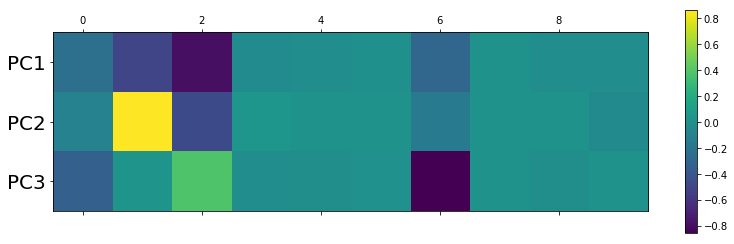

In [88]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],["PC1","PC2","PC3"],fontsize=20)
plt.colorbar()
plt.tight_layout()
plt.show()

In [89]:
print (pd.DataFrame(pca.components_,columns=movie1.columns,index = ["PC1","PC2","PC3"]))

     original_language  production_companies  production_countries  adjbudget  \
PC1          -0.223116             -0.498510             -0.785454  -0.029727   
PC2          -0.092555              0.862718             -0.468969   0.049336   
PC3          -0.331980              0.031212              0.389606  -0.015428   

     adjrevenue   runtime  spoken_languages  vote_average  vote_count  \
PC1   -0.016625  0.008339         -0.287498      0.017034   -0.017228   
PC2    0.022223  0.018993         -0.146746      0.023860    0.025546   
PC3   -0.004933  0.010337         -0.857618      0.028071   -0.007820   

       genres  
PC1 -0.017246  
PC2 -0.034274  
PC3  0.017160  


In [90]:
#Find the most optimal K using Elbow Curve
distortions = [] #Store all data into an empty list 
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k).fit(pcamovie1) #Fit k-means clustering 
    km.fit(pcamovie1)
    distortions.append(sum(np.min(cdist(pcamovie1, km.cluster_centers_, 'euclidean'), axis=1)) / movie1.shape[0]) #average distance

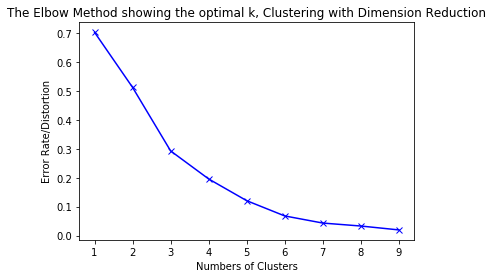

In [91]:
#Plot the Elbow Curve and find the most optimal k
plt.plot(K, distortions, "bx-")
plt.xlabel("Numbers of Clusters")
plt.ylabel("Error Rate/Distortion")
plt.title('The Elbow Method showing the optimal k, Clustering with Dimension Reduction')
plt.show()   #k=6 seems to be the best result, but experience with 2-4

In [64]:
#Experiment with K=2, K=3, K=4 to find the best optimal K
#K=2
km1=KMeans(n_clusters=2)
km1.fit(pcamovie1)
y_means1 = km1.fit_predict(pcamovie1)

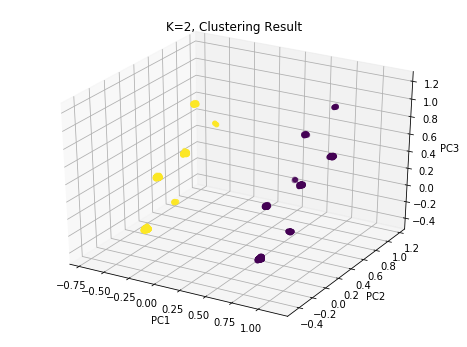

In [94]:
#3D Visualization with K=2
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection="3d") 
x_ax = np.array(pcamovie1.iloc[:, 0]).flatten() 
y_ax = np.array(pcamovie1.iloc[:, 1]).flatten() 
z_ax = np.array(pcamovie1.iloc[:, 2]).flatten()     
ax.scatter(x_ax, y_ax, z_ax, marker='o', c=y_means1) 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 
ax.set_zlabel("PC3") 
ax.set_title("K=2, Clustering Result")
plt.show() 

In [95]:
metrics.silhouette_score(pcamovie1, y_means1, metric="euclidean", sample_size=None, random_state=None)

0.554610926744254

In [96]:
#K=3
km2=KMeans(n_clusters=3)
km2.fit(pcamovie1)
y_means2 = km2.fit_predict(pcamovie1)

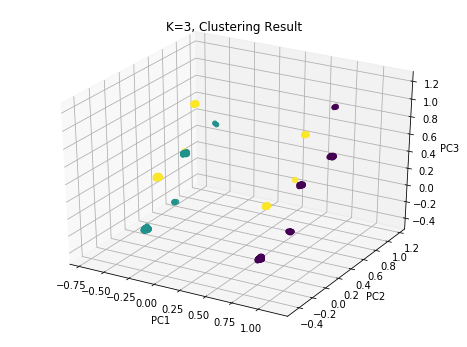

In [97]:
#3D Visualization with K=3
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection="3d") 
x_ax = np.array(pcamovie1.iloc[:, 0]).flatten() 
y_ax = np.array(pcamovie1.iloc[:, 1]).flatten() 
z_ax = np.array(pcamovie1.iloc[:, 2]).flatten()     
ax.scatter(x_ax, y_ax, z_ax, marker='o', c=y_means2) 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 
ax.set_zlabel("PC3") 
ax.set_title("K=3, Clustering Result")
plt.show() 

In [74]:
metrics.silhouette_score(pcamovie1, y_means2, metric="euclidean", sample_size=None, random_state=None)

0.72245505954644

In [98]:
#K=4
km3=KMeans(n_clusters=4)
km3.fit(pcamovie1)
y_means3 = km3.fit_predict(pcamovie1)

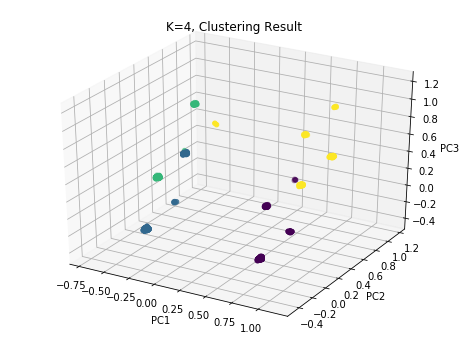

In [99]:
#3D Visualization with K=4
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection="3d") 
x_ax = np.array(pcamovie1.iloc[:, 0]).flatten() 
y_ax = np.array(pcamovie1.iloc[:, 1]).flatten() 
z_ax = np.array(pcamovie1.iloc[:, 2]).flatten()     
ax.scatter(x_ax, y_ax, z_ax, marker='o', c=y_means3) 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 
ax.set_zlabel("PC3") 
ax.set_title("K=4, Clustering Result")
plt.show() 

In [72]:
metrics.silhouette_score(pcamovie1, y_means3, metric="euclidean", sample_size=None, random_state=None)

0.7960075578345063